In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from tqdm import tqdm
import pickle
import copy

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
import torch_scatter
from scripts.utils.data_utils import LigandDataset

from rdkit import Chem
from rdkit.Chem import Descriptors, rdmolops
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from IPython.display import SVG
from cairosvg import svg2png

from sklearn.metrics import roc_curve, auc, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [363]:
from PIL import Image
from io import BytesIO

def show_mol(drawer, mol, preds, legend='', highlightAtoms=[], highlightAtomColors={}):
    opts = drawer.drawOptions()
    opts.maxFontSize = 12
    for i, prob in enumerate(preds):
        opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol() + ' (' +str(np.round(prob[0],2)) + ')'
    drawer.DrawMolecule(mol,legend=legend, highlightAtoms=highlightAtoms, highlightAtomColors=highlightAtomColors)
    # drawer.FinishDrawing()
    bio = BytesIO(drawer.GetDrawingText())
    return Image.open(bio)

def show_images(imgs, buffer=5):
    height = 0
    width = 0
    for img in imgs:
        height = max(height,img.height)
        width += img.width
    width += buffer*(len(imgs)-1)
    res = Image.new("RGBA",(width,height))
    x = 0
    for img in imgs:
        res.paste(img,(x,0))
        x += img.width + buffer
    return res

In [5]:
#Load model

gat_path = 'models/params_gat.pt'

gat = torch_geometric.nn.GAT(-1, 20, num_layers=2, out_channels=1, dropout=0.1)
gat.load_state_dict(torch.load(gat_path, map_location=torch.device('cpu')))
gat.eval()

gcn_path = 'models/params_gcn.pt'

gcn = torch_geometric.nn.GCN(-1, 20, num_layers=2, out_channels=1, dropout=0.1)
gcn.load_state_dict(torch.load(gcn_path, map_location=torch.device('cpu')))
gcn.eval()

# Load test data
test_data = torch.load('data/test_dataset_smiles.pt')
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

# Loss

In [289]:
#functions to calculate loss on test
def predict(model, batch, device):
    """ Predice node-wise probabilities of being a coordinating atom given a batch. """
    model.to(device)
    batch = batch.to(device)
    
    out_logits = model(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
    out_probs = torch.nn.functional.sigmoid(out_logits)
    return out_probs

def compute_batch_loss(preds: torch.Tensor, labels: torch.Tensor, inds: torch.Tensor):
    """ 
    Computes a cross-entropy loss for each atom.
    Then, computes the mean of that loss for each ligand, and then across all ligands in the batch
    Parameters
    ----------
    preds : torch.Tensor (N,1)
        Atom-wise predicted logits for not-being or being a coordinating atom
    labels : torch.Tensor (N,1)
        Atom-wise labels for whether it isn't or is a coordinating atom
    inds : torch.Tensor (batch_size+1)
        The indices defining the ligands within each batch. Uses the batch.ptr generated by the torch_geometric dataloader.
    Return
    ------
    torch.Tensor (1,)
        Mean batch loss
    """
    # this is (N,2) for some reason
    loss_per_node = torch.nn.functional.binary_cross_entropy(preds, labels, reduction='none',
                                                             weight=torch.Tensor([1]).to(preds.device))
    # Compute the mean cross-entropy across each individual graph, then the mean across the entire batch
    # graph_sizes = torch.diff(inds)
    # segment_ids = torch.repeat_interleave(torch.arange(len(graph_sizes), device=preds.device), graph_sizes)
    # graph_losses = torch_scatter.scatter_mean(loss_per_node, segment_ids, dim=0)
    # return graph_losses.mean()
    
    ## Average negative and positive losses separately per graph
    graph_sizes = torch.diff(inds)
    # Get how many ones/zeros are in each individual graph
    num_ones_per_graph = torch.Tensor([len(labels[inds[i-1]:inds[i]].nonzero()) for i in range(1,len(inds))],
                                     ).to(torch.long)
    num_zeros_per_graph = torch.Tensor([len(torch.where(labels[inds[i-1]:inds[i]]==0)[0]) for i in range(1,len(inds))],
                                     ).to(torch.long)
    ones_seg_ids = torch.repeat_interleave(torch.arange(len(num_ones_per_graph)), num_ones_per_graph).to(preds.device)
    zeros_seg_ids = torch.repeat_interleave(torch.arange(len(num_zeros_per_graph)), num_zeros_per_graph).to(preds.device)
    # compute mean loss for each pos/neg for each graph
    pos_loss = torch_scatter.scatter_mean(loss_per_node[labels.flatten().nonzero().flatten()], ones_seg_ids, dim=0)
    neg_loss = torch_scatter.scatter_mean(loss_per_node[torch.where(labels==0)[0]], zeros_seg_ids, dim=0)
    combined_loss_per_graph = pos_loss + neg_loss # element-wise for each graph

    # pred_num_one = torch_scatter.scatter_add(loss_per_node[labels.flatten().nonzero().flatten()], ones_seg_ids, dim=0)
    # pred_num_zero = torch_scatter.scatter_add(loss_per_node[torch.where(labels==0)[0]], zeros_seg_ids, dim=0)
    
    return (combined_loss_per_graph.mean())
            # + 0.5*torch.mean(torch.square(pred_num_one/denticities - 1))
            # + 0.01*torch.mean(torch.square(pred_num_zero/(natoms-denticities))))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

pred_loss = 0

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_probs = 1-batch.y.to(torch.float64).to(device)
        loss = compute_batch_loss(out_probs, batch.y.to(torch.float64), batch.ptr)
        pred_opp_loss += loss.item()
pred_loss = pred_loss / (i+1)

pred_loss

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

gat_preds = []
gat_labels = []
gat_denticities_label = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_logits = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        gat_preds.append(out_probs.detach().cpu().numpy())
        gat_labels.append(batch.y.detach().cpu().numpy())
        gat_denticities_label.append(batch.denticity.detach().cpu().numpy())
gat_preds = np.concatenate(gat_preds)
gat_labels = np.concatenate(gat_labels)
gat_denticities_labels = np.concatenate(gat_denticities_label)

cpu


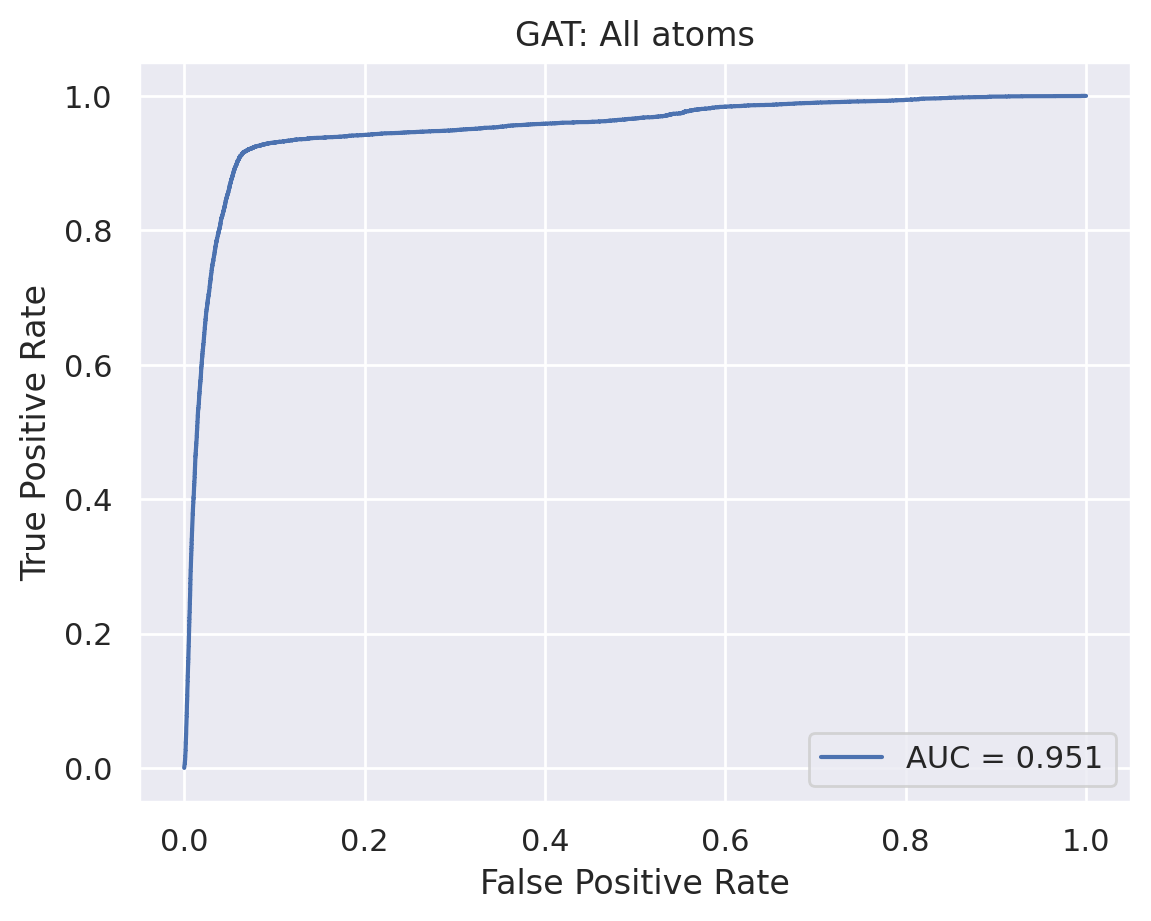

In [74]:
fpr, tpr, thresholds = roc_curve(gat_labels, gat_preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=200)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate',)
plt.ylabel('True Positive Rate')
plt.title('GAT: All atoms')
plt.legend([f'AUC = {roc_auc:.3}'])
plt.savefig('figures/gat_rocauc_all_atoms.png')
plt.show()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

gcn_preds = []
gcn_labels = []
gcn_denticities_label = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_logits = gcn(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        gcn_preds.append(out_probs.detach().cpu().numpy())
        gcn_labels.append(batch.y.detach().cpu().numpy())
        gcn_denticities_label.append(batch.denticity.detach().cpu().numpy())
gcn_preds = np.concatenate(gcn_preds)
gcn_labels = np.concatenate(gcn_labels)
gcn_denticities_labels = np.concatenate(gcn_denticities_label)

cpu


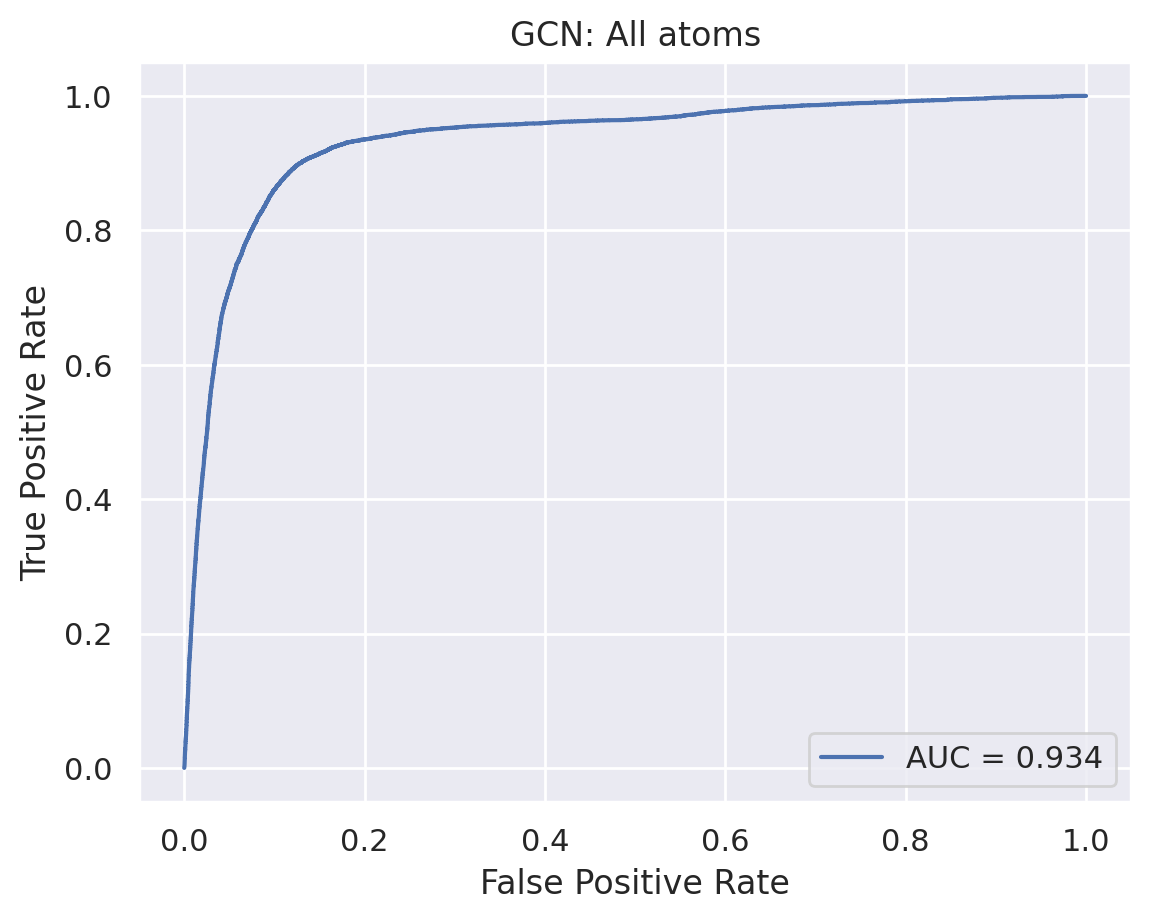

In [73]:
fpr, tpr, thresholds = roc_curve(gcn_labels, gcn_preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=200)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate',)
plt.ylabel('True Positive Rate')
plt.title('GCN: All atoms')
plt.legend([f'AUC = {roc_auc:.3}'])
plt.savefig('figures/gcn_rocauc_all_atoms.png')
plt.show()

# Confusion Matrices

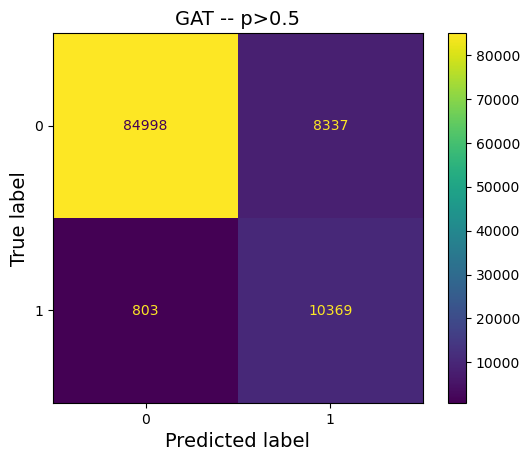

In [9]:
threshold = 0.5
cm = confusion_matrix(gat_labels, gat_preds > threshold)
display = ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d')
plt.title('GAT -- p>0.5')
plt.savefig('figures/gat_confuse_p_05.png')
plt.show()

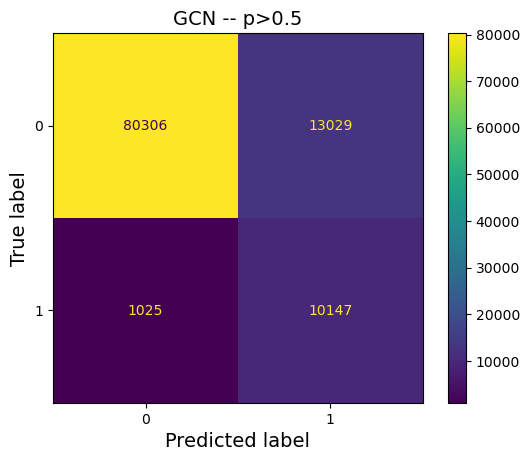

In [10]:
threshold = 0.5
cm = confusion_matrix(gcn_labels, gcn_preds > threshold)
display = ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d')
plt.title('GCN -- p>0.5')
plt.savefig('figures/gcn_confuse_p_05.png')
plt.show()

### Increase threshold

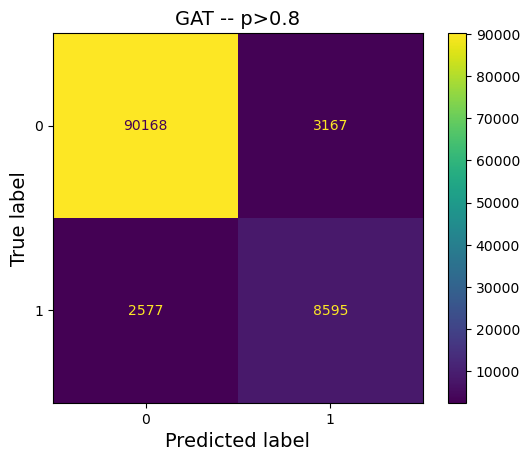

In [11]:
threshold = 0.8
cm = confusion_matrix(gat_labels, gat_preds > threshold)
display = ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d')
plt.title('GAT -- p>0.8')
plt.savefig('figures/gat_confuse_p_08.png')
plt.show()

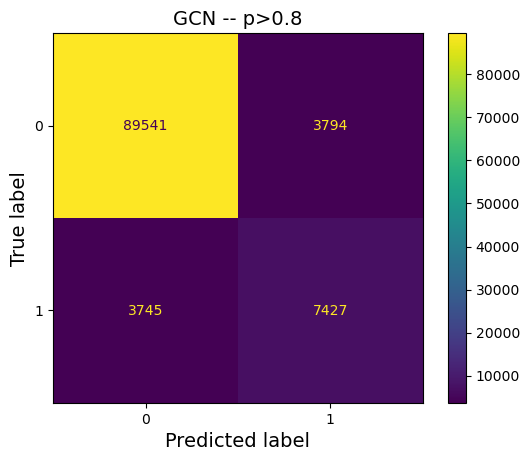

In [12]:
threshold = 0.8
cm = confusion_matrix(gcn_labels, gcn_preds > threshold)
display = ConfusionMatrixDisplay(confusion_matrix=cm).plot(values_format='d')
plt.title('GCN -- p>0.8')
plt.savefig('figures/gcn_confuse_p_08.png')
plt.show()

## Denticity

In [13]:
def predict_denticities(preds: torch.Tensor, inds: torch.Tensor, threshold):
    """ 
    """
    coord_pred = (preds > threshold).to(torch.long)
    
    graph_sizes = torch.diff(inds)
    
    segment_ids = torch.repeat_interleave(torch.arange(len(graph_sizes), device=preds.device), graph_sizes)
    denticity_pred = torch_scatter.scatter_add(coord_pred, segment_ids, dim=0)
    return denticity_pred

In [14]:
threshold = 0.5

In [15]:
gat_dent_preds = []
gat_dent_labels = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_logits = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        gat_dent_preds.append(predict_denticities(out_probs, batch.ptr, threshold).detach().cpu().numpy())
        gat_dent_labels.append(batch.denticity.detach().cpu().numpy())
gat_dent_preds = np.concatenate(gat_dent_preds)
gat_dent_labels = np.concatenate(gat_dent_labels)

In [16]:
gcn_dent_preds = []
gcn_dent_labels = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_logits = gcn(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        gcn_dent_preds.append(predict_denticities(out_probs, batch.ptr, threshold).detach().cpu().numpy())
        gcn_dent_labels.append(batch.denticity.detach().cpu().numpy())
gcn_dent_preds = np.concatenate(gcn_dent_preds)
gcn_dent_labels = np.concatenate(gcn_dent_labels)

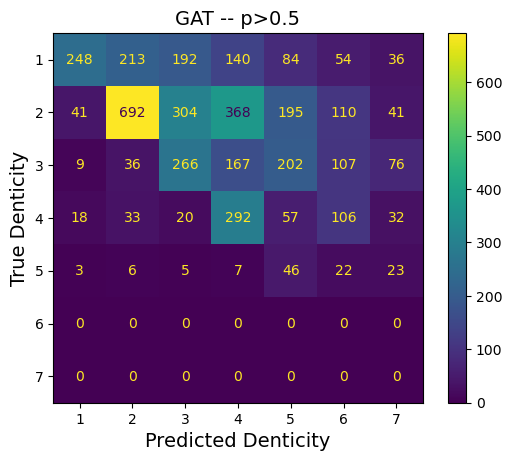

In [17]:
cm = confusion_matrix(gat_dent_labels, gat_dent_preds, labels=np.arange(1,8))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1,8)).plot(values_format='d')
plt.title('GAT -- p>0.5')
plt.ylabel('True Denticity')
plt.xlabel('Predicted Denticity')
plt.savefig('figures/gat_confuse_denticity_05.png')
plt.show()

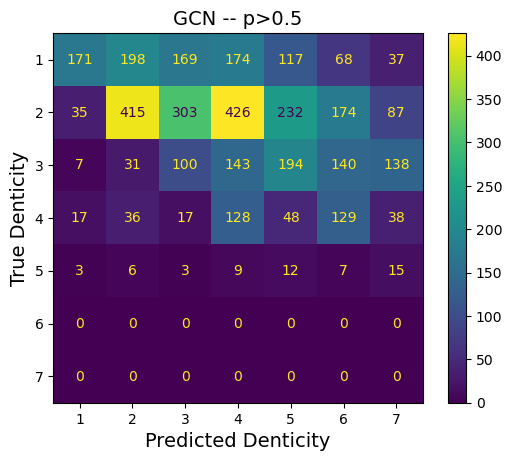

In [18]:
cm = confusion_matrix(gcn_dent_labels, gcn_dent_preds, labels=np.arange(1,8))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1,8)).plot(values_format='d')
plt.title('GCN -- p>0.5')
plt.ylabel('True Denticity')
plt.xlabel('Predicted Denticity')
plt.savefig('figures/gcn_confuse_denticity_05.png')
plt.show()

In [19]:
threshold = 0.8

In [20]:
gat_dent_preds = []
gat_dent_labels = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_logits = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        gat_dent_preds.append(predict_denticities(out_probs, batch.ptr, threshold).detach().cpu().numpy())
        gat_dent_labels.append(batch.denticity.detach().cpu().numpy())
gat_dent_preds = np.concatenate(gat_dent_preds)
gat_dent_labels = np.concatenate(gat_dent_labels)

gcn_dent_preds = []
gcn_dent_labels = []
ptrs = []
smiles = []
last_ptr = None
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        out_logits = gcn(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        out_probs = torch.nn.functional.sigmoid(out_logits)
        gcn_dent_preds.append(predict_denticities(out_probs, batch.ptr, threshold).detach().cpu().numpy())
        gcn_dent_labels.append(batch.denticity.detach().cpu().numpy())
        if last_ptr is not None:
            ptrs.append(batch.ptr.detach().cpu().numpy()[:-1] + last_ptr)
            last_ptr = batch.ptr.detach().cpu().numpy()[-1] + last_ptr
        else:
            ptrs.append(batch.ptr.detach().cpu().numpy()[:-1])
            last_ptr = batch.ptr.detach().cpu().numpy()[-1]
        smiles.append(batch.smiles)
gcn_dent_preds = np.concatenate(gcn_dent_preds)
gcn_dent_labels = np.concatenate(gcn_dent_labels)
ptrs = np.concatenate(ptrs)
smiles = np.concatenate(smiles)

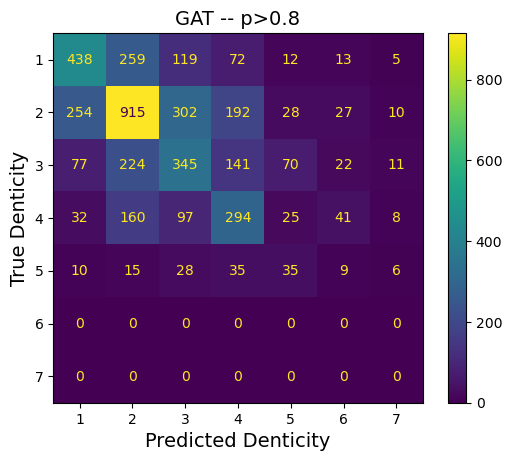

In [21]:
cm = confusion_matrix(gat_dent_labels, gat_dent_preds, labels=np.arange(1,8))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1,8)).plot(values_format='d')
plt.title('GAT -- p>0.8')
plt.ylabel('True Denticity')
plt.xlabel('Predicted Denticity')
plt.savefig('figures/gat_confuse_denticity_08.png')
plt.show()

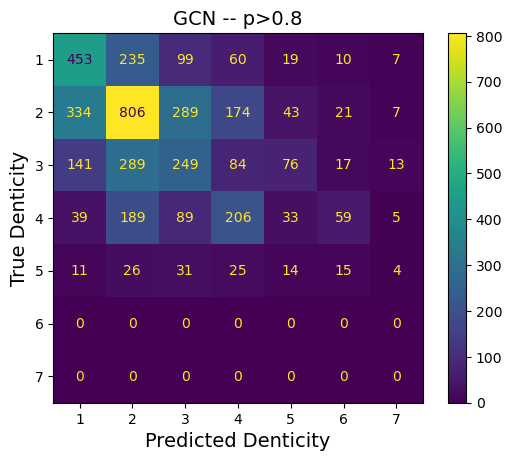

In [22]:
cm = confusion_matrix(gcn_dent_labels, gcn_dent_preds, labels=np.arange(1,8))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(1,8)).plot(values_format='d')
plt.title('GCN -- p>0.8')
plt.ylabel('True Denticity')
plt.xlabel('Predicted Denticity')
plt.savefig('figures/gcn_confuse_denticity_08.png')
plt.show()

# Identity

In [ ]:
mol = Chem.MolFromSmiles(smiles[-67])

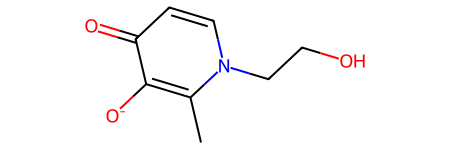

In [34]:
mol

# remember -67

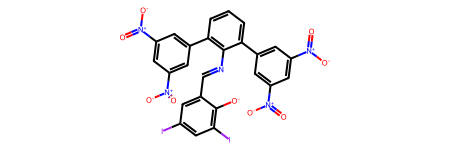

In [798]:
m = Chem.MolFromSmiles('O=[N+]([O-])c1cc(-c2cccc(-c3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)c2/N=C/c2cc(I)cc(I)c2[O-])cc([N+](=O)[O-])c1')
m

In [797]:
[x for x in smiles if Chem.MolFromSmiles(x).HasSubstructMatch(Chem.MolFromSmiles('c4c(O)c(I)cc(I)c4'))]

['[O-]c1c(I)cc(I)cc1I',
 'Cc1noc(C)c1/N=C/c1cc(I)cc(I)c1[O-]',
 'O=C([O-])c1cc(I)cc(I)c1[O-]',
 '[O-]c1c(I)cc(I)cc1/C=N/CCC/N=C/c1cc(I)cc(I)c1[O-]',
 'O=[N+]([O-])c1cc(-c2cccc(-c3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)c2/N=C/c2cc(I)cc(I)c2[O-])cc([N+](=O)[O-])c1',
 '[O-]c1c(I)cc(I)cc1/C=N/CCc1ccccn1']

In [799]:
idx = np.where(smiles == Chem.MolToSmiles(m))[0][0]
idx

2590

In [492]:
idx = np.random.choice(np.arange(0,len(smiles)), 1)[0]
idx

2471

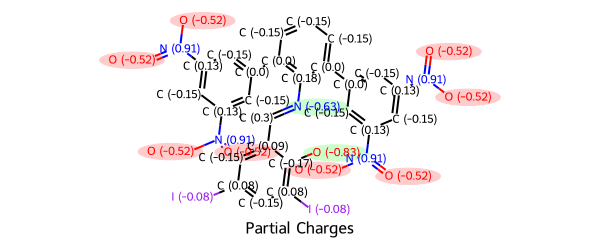

In [800]:
drawer = rdMolDraw2D.MolDraw2DSVG(600,250)
mol = Chem.MolFromSmiles(smiles[idx])


molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
charges = np.array([molec_props.GetMMFFPartialCharge(i) for i, a in enumerate(mol.GetAtoms()) if a.GetAtomicNum() != 1])

labels = gcn_labels[ptrs[idx]:ptrs[idx+1]]

highlightAtoms_true = [i for i, coord in enumerate(labels) if coord == 1]
highlightAtoms_pred = [i for i, charge in enumerate(charges) if charge < -0.5]

both = list(set(highlightAtoms_pred).intersection(set(highlightAtoms_true)))
true_no_pred = list(set(highlightAtoms_true) - set(highlightAtoms_pred))
pred_no_true = list(set(highlightAtoms_pred) - set(highlightAtoms_true))

both_color = (204/255, 255/255, 204/255)
true_no_pred_color = (1,1,0)
pred_no_true_color = (255/255, 204/255, 204/255)

colors = {k : both_color for k in both}
colors.update({k : true_no_pred_color for k in true_no_pred})
colors.update({k : pred_no_true_color for k in pred_no_true})


opts = drawer.drawOptions()
opts.maxFontSize = 12
for i, chg in enumerate(charges):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol() + ' ('+ str(np.round(chg,2)) + ')'
drawer.DrawMolecule(mol, highlightAtoms=set(highlightAtoms_true).union(set(highlightAtoms_pred)),
                    highlightAtomColors=colors,
                   legend='Partial Charges')

drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
# svg2png(bytestring=svg, write_to="figures/mols/mol_pc_4.png")
SVG(svg)

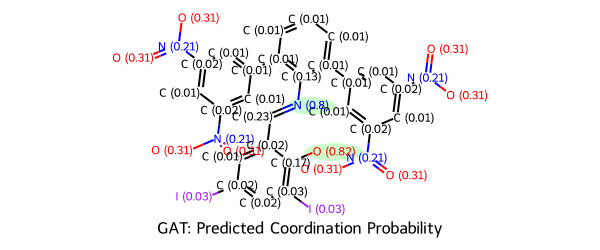

In [801]:
drawer = rdMolDraw2D.MolDraw2DSVG(600,250)
mol = Chem.MolFromSmiles(smiles[idx])

threshold = 0.5
# pc_thres = -0.5

preds = gat_preds[ptrs[idx]:ptrs[idx+1]]
labels = gat_labels[ptrs[idx]:ptrs[idx+1]]

highlightAtoms_true = [i for i, coord in enumerate(labels) if coord == 1]
highlightAtoms_pred = [i for i, pred in enumerate(preds) if pred > threshold]

both = list(set(highlightAtoms_pred).intersection(set(highlightAtoms_true)))
true_no_pred = list(set(highlightAtoms_true) - set(highlightAtoms_pred))
pred_no_true = list(set(highlightAtoms_pred) - set(highlightAtoms_true))

both_color = (204/255, 255/255, 204/255)
true_no_pred_color = (1,1,0)
pred_no_true_color = (255/255, 204/255, 204/255)

colors = {k : both_color for k in both}
colors.update({k : true_no_pred_color for k in true_no_pred})
colors.update({k : pred_no_true_color for k in pred_no_true})

opts = drawer.drawOptions()
opts.maxFontSize = 12

for i, prob in enumerate(preds):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol() + ' (' +str(np.round(prob[0],2)) + ')'
drawer.DrawMolecule(mol, highlightAtoms=set(highlightAtoms_true).union(set(highlightAtoms_pred)),
                    highlightAtomColors=colors,
                   legend='GAT: Predicted Coordination Probability')

drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
# svg2png(bytestring=svg, write_to="figures/mols/mol_gat_pred_4.png")
SVG(svg)

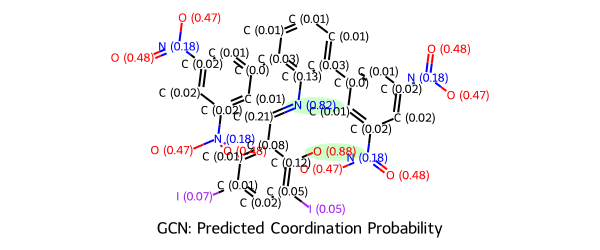

In [803]:
drawer = rdMolDraw2D.MolDraw2DSVG(600,250)
mol = Chem.MolFromSmiles(smiles[idx])

threshold = 0.5
# pc_thres = -0.5

preds = gcn_preds[ptrs[idx]:ptrs[idx+1]]
labels = gcn_labels[ptrs[idx]:ptrs[idx+1]]

highlightAtoms_true = [i for i, coord in enumerate(labels) if coord == 1]
highlightAtoms_pred = [i for i, pred in enumerate(preds) if pred > threshold]

both = list(set(highlightAtoms_pred).intersection(set(highlightAtoms_true)))
true_no_pred = list(set(highlightAtoms_true) - set(highlightAtoms_pred))
pred_no_true = list(set(highlightAtoms_pred) - set(highlightAtoms_true))

both_color = (204/255, 255/255, 204/255)
true_no_pred_color = (1,1,0)
pred_no_true_color = (255/255, 204/255, 204/255)

colors = {k : both_color for k in both}
colors.update({k : true_no_pred_color for k in true_no_pred})
colors.update({k : pred_no_true_color for k in pred_no_true})

opts = drawer.drawOptions()
opts.maxFontSize = 12

for i, prob in enumerate(preds):
    opts.atomLabels[i] = mol.GetAtomWithIdx(i).GetSymbol() + ' (' +str(np.round(prob[0],2)) + ')'
drawer.DrawMolecule(mol, highlightAtoms=set(highlightAtoms_true).union(set(highlightAtoms_pred)),
                    highlightAtomColors=colors,
                   legend='GCN: Predicted Coordination Probability')

drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
# svg2png(bytestring=svg, write_to="figures/mols/mol_gcn_pred_4.png")
SVG(svg)

In [368]:
# threshold = 0.5
# imgs = []

# # partial charge
# molec_props = Chem.AllChem.MMFFGetMoleculeProperties(rdmolops.AddHs(mol))
# preds = np.array([molec_props.GetMMFFPartialCharge(i) for i, a in enumerate(mol.GetAtoms()) if a.GetAtomicNum() != 1])
# labels = gcn_labels[ptrs[idx]:ptrs[idx+1]]

# # GAT
# preds = gat_preds[ptrs[idx]:ptrs[idx+1]]
# labels = gat_labels[ptrs[idx]:ptrs[idx+1]]

# # GCN
# preds = gcn_preds[ptrs[idx]:ptrs[idx+1]]
# labels = gcn_labels[ptrs[idx]:ptrs[idx+1]]

# def add_img()
#     drawer = rdMolDraw2D.MolDraw2DCairo(600,250)
#     mol = Chem.MolFromSmiles(smiles[idx])

#     highlightAtoms_true = [i for i, coord in enumerate(labels) if coord == 1]
#     highlightAtoms_pred = [i for i, pred in enumerate(preds) if pred > threshold]

#     both = list(set(highlightAtoms_pred).intersection(set(highlightAtoms_true)))
#     true_no_pred = list(set(highlightAtoms_true) - set(highlightAtoms_pred))
#     pred_no_true = list(set(highlightAtoms_pred) - set(highlightAtoms_true))

#     both_color = (204/255, 255/255, 204/255)
#     true_no_pred_color = (1,1,0)
#     pred_no_true_color = (255/255, 204/255, 204/255)

#     colors = {k : both_color for k in both}
#     colors.update({k : true_no_pred_color for k in true_no_pred})
#     colors.update({k : pred_no_true_color for k in pred_no_true})

#     highlightAtoms = set(highlightAtoms_true).union(set(highlightAtoms_pred))

#     imgs.append(show_mol(drawer,mol,preds, legend='default palette',
#                          highlightAtoms=highlightAtoms, highlightAtomColors=colors))
# show_images(imgs)

# Training/Val curves

In [60]:
gat_losses = np.load('models/params_gat_losses.npz')
gcn_losses = np.load('models/params_gcn_losses.npz')

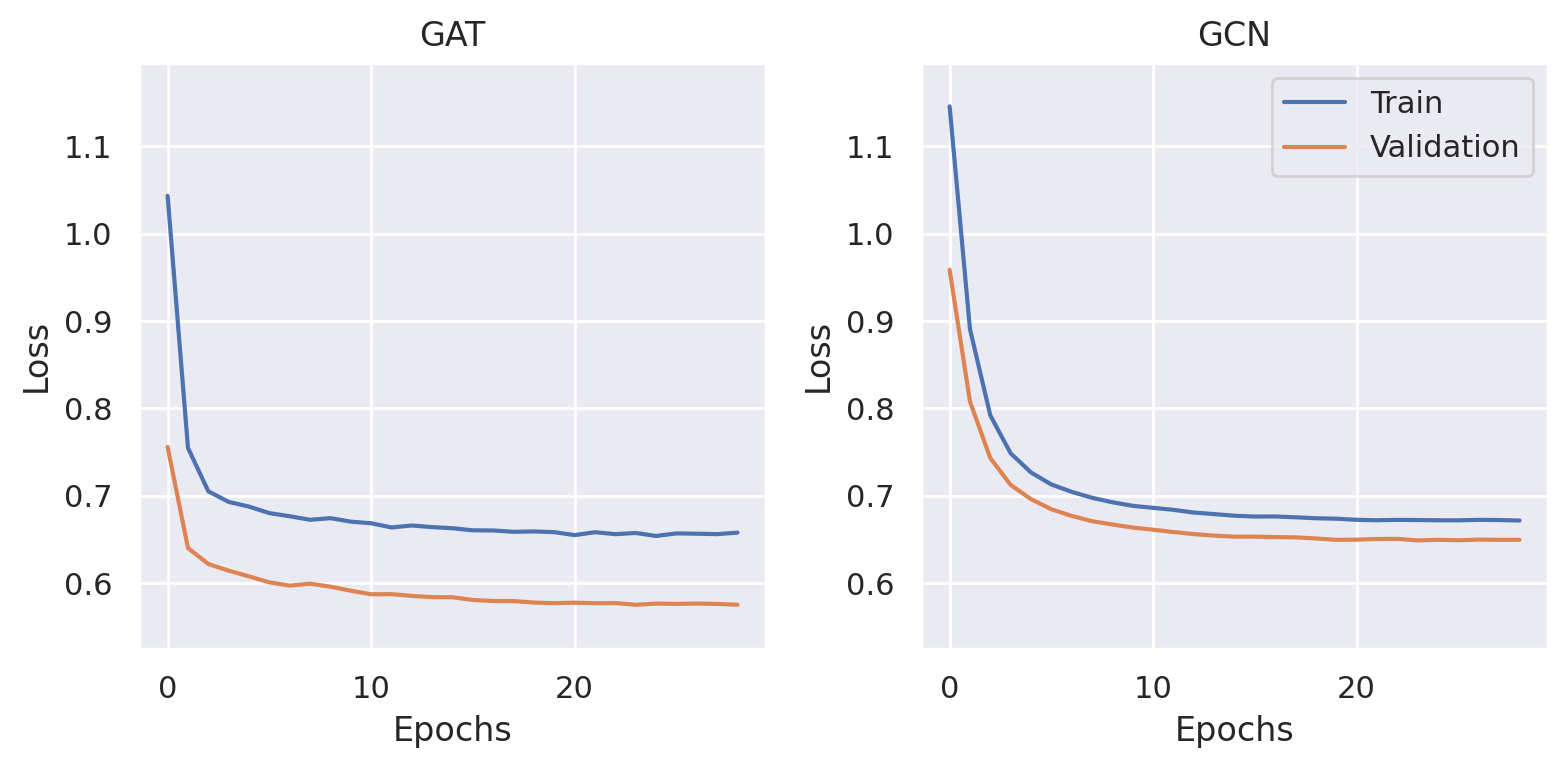

In [808]:
fig, axs = plt.subplots(1,2, dpi=200, figsize=(8,4))
axs[0].plot(np.arange(len(gat_losses['train_losses'])), gat_losses['train_losses'])
axs[0].plot(np.arange(len(gat_losses['val_losses'])), gat_losses['val_losses'])
axs[0].set_xlabel('Epochs')
axs[0].set_title('GAT')
axs[0].set_ylabel('Loss')

axs[0].set_ylim([min(gat_losses['val_losses'])-0.05, max(gcn_losses['train_losses'])+0.05])
axs[1].plot(np.arange(len(gcn_losses['train_losses'])), gcn_losses['train_losses'])
axs[1].plot(np.arange(len(gcn_losses['val_losses'])), gcn_losses['val_losses'])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_title('GCN')
axs[1].set_ylim([min(gat_losses['val_losses'])-0.05, max(gcn_losses['train_losses'])+0.05])
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.savefig('figures/loss_trends.pdf')
plt.show()

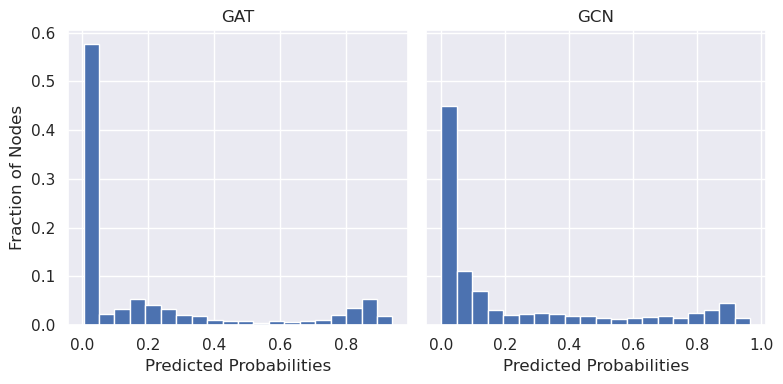

In [805]:
batch = next(iter(test_loader))
out_probs_gat = predict(gat, batch, device)
out_probs_gcn = predict(gcn, batch, device)

probs_gat = out_probs_gat.detach().cpu().numpy()
probs_gcn = out_probs_gcn.detach().cpu().numpy()

fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
axs[0].hist(probs_gat, 20, weights=np.ones(len(probs_gat))/len(probs_gat))
axs[0].set_title('GAT')
axs[1].set_title('GCN')
axs[1].hist(probs_gcn, 20, weights=np.ones(len(probs_gcn))/len(probs_gcn))
axs[1].set_xlabel('Predicted Probabilities')
axs[0].set_xlabel('Predicted Probabilities')
axs[0].set_ylabel('Fraction of Nodes')

plt.tight_layout()
# plt.savefig('figures/prob_distribution.pdf')
plt.show()